# Hierarchical Clustering (Ward) — Student Engagement (Behavior-only)

This notebook runs the full **Ward hierarchical clustering** pipeline:
- Sampling (stratified by `code_module`)
- Feature engineering (VLE engagement + assessment aggregates)
- Preprocessing (median imputation, scaling, `log1p` for count-like features)
- Ward linkage + cluster assignment
- **k selection** by maximizing silhouette (with minimum cluster size constraint)
- Plots & CSV outputs (including KMeans-like curves + driver heatmap)

> **Input**: `student_engagement_analysis.csv` (place it in the same folder as this notebook, or edit `csv_path` below).


In [1]:
from __future__ import annotations

# For inline image display in notebook
from IPython.display import Image, display


In [2]:
# hc_pipeline.py

import os
import warnings
from dataclasses import dataclass
from typing import Any

import numpy as np
import pandas as pd

# Headless-safe plotting (Windows/Server no GUI)
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler


# ============================
# Config
# ============================
@dataclass(frozen=True)
class HCConfig:
    csv_path: str = "student_engagement_analysis.csv"
    output_dir: str = "H_C/hc_outputs"

    sample_size: int = 2000
    random_state: int = 42
    stratify_by: str | None = "code_module"

    # If None -> pick k by max silhouette over k_range; otherwise fix k
    n_clusters: int | None = None
    k_range: tuple[int, int] = (2, 10)
    min_cluster_size: int = 30

    dendrogram_lastp: int = 30

    # transforms
    apply_log1p: bool = True

    # explainability outputs
    top_driver_features: int = 12

    # k-curve plot range (for KMeans-like plots)
    k_curve_range: tuple[int, int] = (2, 9)

    # heatmap settings
    heatmap_top_n: int = 15


# ============================
# IO
# ============================
def load_student_engagement_csv(path: str) -> pd.DataFrame:
    dtype_map = {
        "id_student": "int32",
        "code_module": "category",
        "code_presentation": "category",
        "activity_type": "category",
        "sum": "int32",
        "count": "int32",
        "id_assessment": "int32",
        "assessment_type": "category",
        "date": "float32",
        "weight": "float32",
        "date_submitted": "int32",
        "is_banked": "int8",
        "score": "float32",
        "score_missing": "int8",
        "date_registration": "float32",
        "gender": "category",
        "region": "category",
        "highest_education": "category",
        "imd_band": "category",
        "age_band": "category",
        "num_of_prev_attempts": "int8",
        "studied_credits": "int16",
        "disability": "category",
        "final_result": "category",
        "module_presentation_length": "int16",
        "completion_status": "category",
        "withdrawal_status": "category",
    }

    df = pd.read_csv(path, dtype=dtype_map, low_memory=False)

    expected = set(dtype_map.keys())
    missing = expected.difference(df.columns)
    if missing:
        raise ValueError(f"CSV missing expected columns: {sorted(missing)}")

    return df


# ============================
# Sampling
# ============================
class StudentCourseSampler:
    def __init__(self, sample_size: int, random_state: int, stratify_by: str | None = "code_module") -> None:
        self.sample_size = int(sample_size)
        self.random_state = int(random_state)
        self.stratify_by = stratify_by

    def sample_keys(self, df: pd.DataFrame) -> pd.DataFrame:
        keys = ["id_student", "code_module", "code_presentation"]
        unique_keys = df[keys].drop_duplicates()

        if self.sample_size >= len(unique_keys):
            return unique_keys.reset_index(drop=True)

        rng = np.random.default_rng(self.random_state)

        if self.stratify_by and self.stratify_by in unique_keys.columns:
            parts: list[pd.DataFrame] = []
            for _, g in unique_keys.groupby(self.stratify_by, observed=True):
                n = max(1, int(round(self.sample_size * len(g) / len(unique_keys))))
                n = min(n, len(g))
                idx = rng.choice(g.index.to_numpy(), size=n, replace=False)
                parts.append(unique_keys.loc[idx])

            sampled = pd.concat(parts, axis=0).drop_duplicates()

            if len(sampled) < self.sample_size:
                remaining = unique_keys.merge(sampled, on=keys, how="left", indicator=True)
                remaining = remaining[remaining["_merge"] == "left_only"].drop(columns="_merge")
                add_n = self.sample_size - len(sampled)
                add_idx = rng.choice(remaining.index.to_numpy(), size=add_n, replace=False)
                sampled = pd.concat([sampled, remaining.loc[add_idx]], axis=0)
            elif len(sampled) > self.sample_size:
                sampled = sampled.sample(self.sample_size, random_state=self.random_state)
        else:
            sampled = unique_keys.sample(self.sample_size, random_state=self.random_state)

        return sampled.reset_index(drop=True)


# ============================
# Feature engineering
# ============================
class FeatureEngineer:
    KEY_COLS = ["id_student", "code_module", "code_presentation"]

    def build(self, df_sub: pd.DataFrame) -> pd.DataFrame:
        keys = self.KEY_COLS

        # VLE engagement: sum/count by activity_type
        g = df_sub.groupby(keys + ["activity_type"], observed=True)[["sum", "count"]].sum()
        sum_w = g["sum"].unstack("activity_type", fill_value=0)
        cnt_w = g["count"].unstack("activity_type", fill_value=0)

        sum_w.columns = [f"sum_{c}" for c in sum_w.columns.astype(str)]
        cnt_w.columns = [f"count_{c}" for c in cnt_w.columns.astype(str)]

        engagement = pd.concat([sum_w, cnt_w], axis=1)
        engagement["total_sum"] = sum_w.sum(axis=1)
        engagement["total_count"] = cnt_w.sum(axis=1)

        # Assessment-level data (dedupe per assessment)
        assess_cols = keys + [
            "id_assessment",
            "assessment_type",
            "date",
            "weight",
            "date_submitted",
            "is_banked",
            "score",
            "score_missing",
            "date_registration",
            "gender",
            "region",
            "highest_education",
            "imd_band",
            "age_band",
            "num_of_prev_attempts",
            "studied_credits",
            "disability",
            "final_result",
            "module_presentation_length",
            "completion_status",
            "withdrawal_status",
        ]
        df_assess = df_sub[assess_cols].drop_duplicates(subset=keys + ["id_assessment"])

        # submission delay: can be negative
        df_assess["submission_delay"] = (
            df_assess["date_submitted"].astype("float32") - df_assess["date"].astype("float32")
        )

        numeric_agg = df_assess.groupby(keys, observed=True).agg(
            n_assessments=("id_assessment", "nunique"),
            mean_score=("score", "mean"),
            median_score=("score", "median"),
            min_score=("score", "min"),
            max_score=("score", "max"),
            pct_score_missing=("score_missing", "mean"),
            mean_weight=("weight", "mean"),
            mean_submission_delay=("submission_delay", "mean"),
            pct_banked=("is_banked", "mean"),
            studied_credits=("studied_credits", "max"),
            num_of_prev_attempts=("num_of_prev_attempts", "max"),
            module_presentation_length=("module_presentation_length", "max"),
        )

        # categorical columns for interpretation only (NOT used for clustering)
        cat_cols = [
            "gender",
            "region",
            "highest_education",
            "imd_band",
            "age_band",
            "disability",
            "final_result",
            "completion_status",
            "withdrawal_status",
        ]
        cats = df_assess.sort_values(keys + ["id_assessment"]).groupby(keys, observed=True)[cat_cols].first()
        cats = cats.drop(columns=[c for c in cats.columns if c in keys], errors="ignore")

        features = engagement.join(numeric_agg, how="left").join(cats, how="left").reset_index()
        return features


# ============================
# Design matrix
# ============================
@dataclass(frozen=True)
class DesignMatrixSpec:
    numeric_cols: list[str]


class DesignMatrixBuilder:
    def __init__(self, apply_log1p: bool = True) -> None:
        self.apply_log1p = bool(apply_log1p)
        self.preprocessor: ColumnTransformer | None = None
        self.spec: DesignMatrixSpec | None = None
        self.log_cols_: list[str] = []
        self.lin_cols_: list[str] = []

    @staticmethod
    def _safe_log1p_nonneg(X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=np.float64)
        X = np.maximum(X, 0.0)
        return np.log1p(X)

    def infer_spec(self, features: pd.DataFrame) -> DesignMatrixSpec:
        sum_cols = [c for c in features.columns if c.startswith("sum_")]
        cnt_cols = [c for c in features.columns if c.startswith("count_")]

        base_numeric = sum_cols + cnt_cols + [
            "total_sum",
            "total_count",
            "n_assessments",
            "mean_score",
            "median_score",
            "min_score",
            "max_score",
            "pct_score_missing",
            "mean_weight",
            "mean_submission_delay",
            "pct_banked",
        ]
        numeric_cols = [c for c in base_numeric if c in features.columns]
        return DesignMatrixSpec(numeric_cols=numeric_cols)

    def _split_numeric_cols_for_log(self, numeric_cols: list[str]) -> tuple[list[str], list[str]]:
        log_cols = []
        for c in numeric_cols:
            if c.startswith("sum_") or c.startswith("count_"):
                log_cols.append(c)
            elif c in {"total_sum", "total_count", "n_assessments"}:
                log_cols.append(c)
        lin_cols = [c for c in numeric_cols if c not in set(log_cols)]
        return log_cols, lin_cols

    def build(self, features: pd.DataFrame, spec: DesignMatrixSpec | None = None) -> np.ndarray:
        if spec is None:
            spec = self.infer_spec(features)
        self.spec = spec

        if not spec.numeric_cols:
            raise ValueError("No numeric columns found for clustering. Check feature engineering outputs.")

        if self.apply_log1p:
            log_cols, lin_cols = self._split_numeric_cols_for_log(spec.numeric_cols)
        else:
            log_cols, lin_cols = [], spec.numeric_cols

        self.log_cols_, self.lin_cols_ = log_cols, lin_cols

        num_log_pipe = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("log1p", FunctionTransformer(self._safe_log1p_nonneg)),
                ("scaler", StandardScaler()),
            ]
        )
        num_lin_pipe = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )

        transformers = []
        if log_cols:
            transformers.append(("num_log", num_log_pipe, log_cols))
        if lin_cols:
            transformers.append(("num_lin", num_lin_pipe, lin_cols))

        preprocessor = ColumnTransformer(
            transformers=transformers,
            remainder="drop",
            sparse_threshold=0.0,
        )

        X = preprocessor.fit_transform(features)
        X = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
        X = np.asarray(X, dtype=np.float64)

        if not np.isfinite(X).all():
            n_bad = int((~np.isfinite(X)).sum())
            raise ValueError(f"Design matrix contains non-finite values (count={n_bad}).")

        self.preprocessor = preprocessor
        return X


# ============================
# Outputs
# ============================
class OutputWriter:
    def __init__(self, output_dir: str) -> None:
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

    def save_cluster_outputs(
        self,
        features: pd.DataFrame,
        labels: np.ndarray,
        numeric_cols: list[str],
        top_n_drivers: int = 12,
    ) -> dict[str, Any]:
        out = features.copy()
        out["cluster"] = labels

        assign_path = os.path.join(self.output_dir, "student_course_clusters_sample.csv")
        out[["id_student", "code_module", "code_presentation", "cluster"]].to_csv(assign_path, index=False)

        prof = out.groupby("cluster")[numeric_cols].mean(numeric_only=True)
        prof["n"] = out["cluster"].value_counts().sort_index()
        prof_path = os.path.join(self.output_dir, "cluster_profile_numeric.csv")
        prof.to_csv(prof_path)

        dist_paths: dict[str, str] = {}
        for col in ["final_result", "completion_status", "withdrawal_status"]:
            if col in out.columns:
                dist = (
                    out.groupby("cluster")[col]
                    .value_counts(normalize=True)
                    .rename("proportion")
                    .reset_index()
                )
                path = os.path.join(self.output_dir, f"cluster_{col}_distribution.csv")
                dist.to_csv(path, index=False)
                dist_paths[col] = path

        drivers_path = self._save_top_numeric_drivers(out, numeric_cols, top_n=top_n_drivers)

        return {
            "assignments_csv": assign_path,
            "numeric_profile_csv": prof_path,
            "outcome_distribution_csvs": dist_paths,
            "top_numeric_drivers_csv": drivers_path,
        }

    def _save_top_numeric_drivers(self, out: pd.DataFrame, numeric_cols: list[str], top_n: int = 12) -> str:
        path = os.path.join(self.output_dir, "cluster_top_numeric_drivers.csv")

        df_num = out[numeric_cols].copy()
        df_num = df_num.fillna(df_num.median(numeric_only=True))

        overall_mean = df_num.mean(axis=0)
        overall_std = df_num.std(axis=0).replace(0, 1)

        rows = []
        for c, g in out.groupby("cluster"):
            c_mean = g[numeric_cols].fillna(df_num.median(numeric_only=True)).mean(axis=0)
            effect = (c_mean - overall_mean) / overall_std

            top_pos = effect.sort_values(ascending=False).head(top_n)
            top_neg = effect.sort_values(ascending=True).head(top_n)

            for feat, val in top_pos.items():
                rows.append({"cluster": int(c), "direction": "higher", "feature": feat, "effect_size": float(val)})
            for feat, val in top_neg.items():
                rows.append({"cluster": int(c), "direction": "lower", "feature": feat, "effect_size": float(val)})

        pd.DataFrame(rows).to_csv(path, index=False)
        return path


# ============================
# Plotting
# ============================
class ClusterPlotter:
    def __init__(self, output_dir: str) -> None:
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

    def plot_truncated_dendrogram(self, Z: np.ndarray, n_clusters: int, lastp: int) -> str:
        out_path = os.path.join(self.output_dir, "hierarchical_dendrogram_truncated.png")
        color_threshold = Z[-(n_clusters - 1), 2] if n_clusters > 1 else 0.0

        plt.figure(figsize=(12, 6))
        dendrogram(
            Z,
            truncate_mode="lastp",
            p=lastp,
            leaf_rotation=90,
            leaf_font_size=10,
            show_contracted=True,
            color_threshold=color_threshold,
        )
        plt.title("Hierarchical Clustering Dendrogram (Ward linkage, truncated)")
        plt.xlabel("Cluster size (or sample index)")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()
        return out_path

    def plot_pca_clusters(self, X: np.ndarray, labels: np.ndarray) -> str:
        out_path = os.path.join(self.output_dir, "hierarchical_clusters_pca.png")
        pca = PCA(n_components=2, random_state=0)
        X_2d = pca.fit_transform(X)

        plt.figure(figsize=(7, 7))
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=12)
        plt.title("PCA Projection of Sample (colored by cluster)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()
        return out_path

    def plot_final_result_by_cluster(self, features: pd.DataFrame, labels: np.ndarray) -> str:
        """KMeans-like plot: final_result distribution by cluster (counts)."""
        out_path = os.path.join(self.output_dir, "hc_final_result_by_cluster.png")

        df = features.copy()
        df["cluster"] = labels

        if "final_result" not in df.columns:
            raise ValueError("features does not contain 'final_result' column, cannot plot.")

        ct = (
            df.groupby(["final_result", "cluster"])
            .size()
            .unstack("cluster", fill_value=0)
            .sort_index()
        )

        plt.figure(figsize=(8, 6))
        x = np.arange(len(ct.index))
        n_clusters = ct.shape[1]
        width = 0.8 / max(n_clusters, 1)

        for i, c in enumerate(ct.columns):
            plt.bar(x + (i - (n_clusters - 1) / 2) * width, ct[c].values, width=width, label=str(c))

        plt.xticks(x, ct.index.astype(str))
        plt.xlabel("final_result")
        plt.ylabel("count")
        plt.title("final_result distribution by Hierarchical cluster (Ward)")
        plt.legend(title="cluster")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()
        return out_path

    def plot_silhouette_curve(self, df_k: pd.DataFrame) -> str:
        out_path = os.path.join(self.output_dir, "hc_silhouette_curve.png")
        best_idx = df_k["silhouette"].idxmax()
        best_k = int(df_k.loc[best_idx, "k"])
        best_s = float(df_k.loc[best_idx, "silhouette"])

        plt.figure(figsize=(9, 5))
        plt.plot(df_k["k"], df_k["silhouette"], marker="D")
        plt.axvline(best_k, linestyle="--")
        plt.title(f"Silhouette Score Curve (Hierarchical, best k={best_k}, score={best_s:.3f})")
        plt.xlabel("k")
        plt.ylabel("silhouette score")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()
        return out_path

    def plot_ward_distance_elbow(self, df_k: pd.DataFrame) -> str:
        out_path = os.path.join(self.output_dir, "hc_ward_distance_elbow.png")
        plt.figure(figsize=(9, 5))
        plt.plot(df_k["k"], df_k["ward_merge_distance"], marker="D")
        plt.xlabel("k")
        plt.ylabel("Ward merge distance (cut threshold)")
        plt.title("Ward Distance Curve (distortion-like) for Hierarchical Clustering")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()
        return out_path

    def plot_cluster_driver_heatmap(
        self,
        features: pd.DataFrame,
        labels: np.ndarray,
        numeric_cols: list[str],
        top_n: int = 15,
        filename: str = "hc_cluster_driver_heatmap.png",
    ) -> str:
        """
        Heatmap like your example:
        - rows: clusters
        - cols: most discriminative numeric features
        - values: z-scored cluster means (relative to overall mean/std)
        """
        out_path = os.path.join(self.output_dir, filename)

        df = features.copy()
        df["cluster"] = labels

        Xnum = df[numeric_cols].copy()
        Xnum = Xnum.replace([np.inf, -np.inf], np.nan)
        Xnum = Xnum.fillna(Xnum.median(numeric_only=True))

        mu = Xnum.mean(axis=0)
        sd = Xnum.std(axis=0).replace(0, 1)

        cluster_means = df.groupby("cluster")[numeric_cols].mean(numeric_only=True)
        z = (cluster_means - mu) / sd

        # pick top features by spread across clusters
        spread = (z.max(axis=0) - z.min(axis=0)).sort_values(ascending=False)
        top_feats = spread.head(top_n).index.tolist()
        z = z[top_feats]

        # symmetric color scale (more interpretable)
        vmax = float(np.nanmax(np.abs(z.values))) if z.size else 1.0
        if not np.isfinite(vmax) or vmax <= 0:
            vmax = 1.0

        plt.figure(figsize=(max(10, 0.6 * len(top_feats)), max(3, 0.85 * z.shape[0])))
        im = plt.imshow(
            z.values,
            aspect="auto",
            vmin=-vmax,
            vmax=vmax,
            interpolation="nearest",
        )
        plt.colorbar(im)

        plt.xticks(np.arange(len(top_feats)), top_feats, rotation=45, ha="right")
        plt.yticks(np.arange(z.shape[0]), [str(c) for c in z.index])

        plt.xlabel("features")
        plt.ylabel("cluster")
        plt.title("Hierarchical Cluster Driver Heatmap (z-scored cluster means)")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()
        return out_path


# ============================
# Pipeline
# ============================
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None


@dataclass(frozen=True)
class EvaluationResult:
    sample_size: int
    k: int
    silhouette: float
    davies_bouldin: float
    calinski_harabasz: float
    cluster_sizes: dict[int, int]


class HierarchicalClusteringPipeline:
    def __init__(self, cfg: HCConfig) -> None:
        self.cfg = cfg
        os.makedirs(self.cfg.output_dir, exist_ok=True)

        self.df: pd.DataFrame | None = None
        self.sample_keys: pd.DataFrame | None = None
        self.df_sub: pd.DataFrame | None = None

        self.features: pd.DataFrame | None = None
        self.X: np.ndarray | None = None

        self.k_metrics: pd.DataFrame | None = None
        self.n_clusters: int | None = None

        self.Z: np.ndarray | None = None
        self.labels: np.ndarray | None = None

        self.feature_engineer = FeatureEngineer()
        self.sampler = StudentCourseSampler(
            sample_size=self.cfg.sample_size,
            random_state=self.cfg.random_state,
            stratify_by=self.cfg.stratify_by,
        )
        self.design_builder = DesignMatrixBuilder(apply_log1p=self.cfg.apply_log1p)
        self.plotter = ClusterPlotter(self.cfg.output_dir)
        self.writer = OutputWriter(self.cfg.output_dir)

    def load(self) -> "HierarchicalClusteringPipeline":
        self.df = load_student_engagement_csv(self.cfg.csv_path)
        return self

    def sample(self) -> "HierarchicalClusteringPipeline":
        if self.df is None:
            raise RuntimeError("Call load() before sample().")

        self.sample_keys = self.sampler.sample_keys(self.df)
        self.df_sub = self.df.merge(
            self.sample_keys,
            on=["id_student", "code_module", "code_presentation"],
            how="inner",
        )
        return self

    def engineer_features(self) -> "HierarchicalClusteringPipeline":
        if self.df_sub is None:
            raise RuntimeError("Call sample() before engineer_features().")
        self.features = self.feature_engineer.build(self.df_sub)
        return self

    def build_design_matrix(self) -> "HierarchicalClusteringPipeline":
        if self.features is None:
            raise RuntimeError("Call engineer_features() before build_design_matrix().")
        self.X = self.design_builder.build(self.features)
        return self

    def _pick_k_by_silhouette(self) -> int:
        if self.X is None:
            raise RuntimeError("Design matrix not built.")

        k_min, k_max = self.cfg.k_range
        min_size = int(self.cfg.min_cluster_size)

        rows_constrained: list[dict[str, float]] = []
        rows_all: list[dict[str, float]] = []

        best_k_constrained: int | None = None
        best_sil_constrained = -1e18

        best_k_any: int | None = None
        best_sil_any = -1e18

        Z = linkage(self.X, method="ward")

        for k in range(k_min, k_max + 1):
            labels0 = fcluster(Z, t=k, criterion="maxclust").astype(int)
            if len(np.unique(labels0)) < 2:
                continue

            sil = float(silhouette_score(self.X, labels0))
            db = float(davies_bouldin_score(self.X, labels0))
            ch = float(calinski_harabasz_score(self.X, labels0))
            rows_all.append({"k": float(k), "silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch})

            if sil > best_sil_any:
                best_sil_any = sil
                best_k_any = int(k)

            _, counts = np.unique(labels0, return_counts=True)
            if counts.min() < min_size:
                continue

            rows_constrained.append({"k": float(k), "silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch})
            if sil > best_sil_constrained:
                best_sil_constrained = sil
                best_k_constrained = int(k)

        metrics = pd.DataFrame(rows_constrained if rows_constrained else rows_all).sort_values("k")
        self.k_metrics = metrics
        metrics.to_csv(os.path.join(self.cfg.output_dir, "k_selection_metrics.csv"), index=False)

        if best_k_constrained is not None:
            return best_k_constrained
        if best_k_any is not None:
            return best_k_any
        return int(k_min)

    def fit(self) -> "HierarchicalClusteringPipeline":
        if self.X is None:
            raise RuntimeError("Call build_design_matrix() before fit().")

        self.n_clusters = int(self.cfg.n_clusters) if self.cfg.n_clusters is not None else self._pick_k_by_silhouette()
        self.Z = linkage(self.X, method="ward")
        self.labels = fcluster(self.Z, t=self.n_clusters, criterion="maxclust").astype(int)
        return self

    def evaluate(self) -> EvaluationResult:
        if self.X is None or self.labels is None or self.features is None or self.n_clusters is None:
            raise RuntimeError("Call fit() before evaluate().")

        sil = float(silhouette_score(self.X, self.labels))
        db = float(davies_bouldin_score(self.X, self.labels))
        ch = float(calinski_harabasz_score(self.X, self.labels))

        uniq, cnt = np.unique(self.labels, return_counts=True)
        sizes = {int(u): int(c) for u, c in zip(uniq, cnt)}

        return EvaluationResult(
            sample_size=int(len(self.features)),
            k=int(self.n_clusters),
            silhouette=sil,
            davies_bouldin=db,
            calinski_harabasz=ch,
            cluster_sizes=sizes,
        )

    def plot_core(self) -> dict[str, str]:
        """Core plots: dendrogram + PCA scatter"""
        if self.Z is None or self.labels is None or self.X is None or self.n_clusters is None:
            raise RuntimeError("Call fit() before plot_core().")

        dendro_path = self.plotter.plot_truncated_dendrogram(
            Z=self.Z, n_clusters=self.n_clusters, lastp=self.cfg.dendrogram_lastp
        )
        pca_path = self.plotter.plot_pca_clusters(X=self.X, labels=self.labels)
        return {"dendrogram": dendro_path, "pca": pca_path}

    def evaluate_over_k(self, k_min: int, k_max: int) -> pd.DataFrame:
        """Compute k-curve metrics + ward merge distance curve (distortion-like)."""
        if self.X is None:
            raise RuntimeError("Call build_design_matrix() before evaluate_over_k().")

        Z = linkage(self.X, method="ward")

        rows = []
        for k in range(k_min, k_max + 1):
            labels = fcluster(Z, t=k, criterion="maxclust").astype(int)
            if len(np.unique(labels)) < 2:
                continue

            sil = float(silhouette_score(self.X, labels))
            db = float(davies_bouldin_score(self.X, labels))
            ch = float(calinski_harabasz_score(self.X, labels))

            ward_thr = float(Z[-(k - 1), 2]) if k > 1 else float(Z[-1, 2])

            _, counts = np.unique(labels, return_counts=True)
            min_size = int(counts.min())

            rows.append(
                {
                    "k": int(k),
                    "silhouette": sil,
                    "davies_bouldin": db,
                    "calinski_harabasz": ch,
                    "ward_merge_distance": ward_thr,
                    "min_cluster_size": min_size,
                }
            )

        df = pd.DataFrame(rows).sort_values("k")
        out_csv = os.path.join(self.cfg.output_dir, "hc_k_curve_metrics.csv")
        df.to_csv(out_csv, index=False)
        return df

    def generate_kmeans_like_plots(self) -> dict[str, str]:
        if self.features is None or self.labels is None:
            raise RuntimeError("Call fit() before generate_kmeans_like_plots().")

        # 1) final_result distribution (counts)
        p_final = self.plotter.plot_final_result_by_cluster(self.features, self.labels)

        # 2) k curves
        kmin, kmax = self.cfg.k_curve_range
        df_k = self.evaluate_over_k(kmin, kmax)

        p_sil = self.plotter.plot_silhouette_curve(df_k)
        p_ward = self.plotter.plot_ward_distance_elbow(df_k)

        # 3) driver heatmap (like your example)
        spec = self.design_builder.spec
        if spec is None:
            raise RuntimeError("Design matrix spec missing. Call build_design_matrix() first.")
        p_heat = self.plotter.plot_cluster_driver_heatmap(
            features=self.features,
            labels=self.labels,
            numeric_cols=spec.numeric_cols,
            top_n=int(self.cfg.heatmap_top_n),
        )

        return {
            "final_result_by_cluster": p_final,
            "silhouette_curve": p_sil,
            "ward_distance_elbow": p_ward,
            "driver_heatmap": p_heat,
        }

    def save_outputs(self) -> dict[str, Any]:
        if self.features is None or self.labels is None:
            raise RuntimeError("Call fit() before save_outputs().")
        spec = self.design_builder.spec
        if spec is None:
            raise RuntimeError("Design matrix spec missing. Call build_design_matrix() first.")
        return self.writer.save_cluster_outputs(
            features=self.features,
            labels=self.labels,
            numeric_cols=spec.numeric_cols,
            top_n_drivers=self.cfg.top_driver_features,
        )

    def run_all(self) -> dict[str, Any]:
        self.load().sample().engineer_features().build_design_matrix().fit()
        evaluation = self.evaluate()
        core_plots = self.plot_core()
        kmeans_like_plots = self.generate_kmeans_like_plots()
        outputs = self.save_outputs()
        return {
            "evaluation": evaluation,
            "core_plots": core_plots,
            "kmeans_like_plots": kmeans_like_plots,
            "outputs": outputs,
            "k_selection_metrics_csv": os.path.join(self.cfg.output_dir, "k_selection_metrics.csv"),
            "k_curve_metrics_csv": os.path.join(self.cfg.output_dir, "hc_k_curve_metrics.csv"),
        }


In [3]:
# ============================
# Configuration (edit if needed)
# ============================
cfg = HCConfig(
    csv_path="student_engagement_analysis.csv",  # <- change if your CSV is elsewhere
    output_dir="H_C/hc_outputs",

    sample_size=2000,
    random_state=42,
    stratify_by="code_module",

    # None -> auto-pick via silhouette over k_range
    n_clusters=None,
    k_range=(2, 10),
    min_cluster_size=30,

    dendrogram_lastp=30,

    apply_log1p=True,
    top_driver_features=12,

    # KMeans-like k curve plots (silhouette + ward distance)
    k_curve_range=(2, 9),

    # Driver heatmap
    heatmap_top_n=15,
)

print(cfg)


HCConfig(csv_path='student_engagement_analysis.csv', output_dir='hc_outputs', sample_size=2000, random_state=42, stratify_by='code_module', n_clusters=None, k_range=(2, 10), min_cluster_size=30, dendrogram_lastp=30, apply_log1p=True, top_driver_features=12, k_curve_range=(2, 9), heatmap_top_n=15)


In [4]:
# ============================
# Run the pipeline end-to-end
# ============================
if not os.path.exists(cfg.csv_path):
    raise FileNotFoundError(
        f"Cannot find CSV at: {cfg.csv_path}\n"
        "Put 'student_engagement_analysis.csv' next to this notebook, or edit cfg.csv_path."
    )

pipe = HierarchicalClusteringPipeline(cfg)
results = pipe.run_all()

ev = results["evaluation"]
print(f"Hierarchical (Ward) clustering on sample_size={ev.sample_size} with k={ev.k}")
print(
    f"Silhouette: {ev.silhouette:.4f} | "
    f"Davies-Bouldin: {ev.davies_bouldin:.4f} | "
    f"Calinski-Harabasz: {ev.calinski_harabasz:.2f}"
)
print("Cluster sizes:", ev.cluster_sizes)

results


Hierarchical (Ward) clustering on sample_size=2000 with k=2
Silhouette: 0.3226 | Davies-Bouldin: 1.4232 | Calinski-Harabasz: 492.85
Cluster sizes: {1: 297, 2: 1703}


{'evaluation': EvaluationResult(sample_size=2000, k=2, silhouette=0.32263243837466077, davies_bouldin=1.4231940308253168, calinski_harabasz=492.85012977048797, cluster_sizes={1: 297, 2: 1703}),
 'core_plots': {'dendrogram': 'hc_outputs\\hierarchical_dendrogram_truncated.png',
  'pca': 'hc_outputs\\hierarchical_clusters_pca.png'},
 'kmeans_like_plots': {'final_result_by_cluster': 'hc_outputs\\hc_final_result_by_cluster.png',
  'silhouette_curve': 'hc_outputs\\hc_silhouette_curve.png',
  'ward_distance_elbow': 'hc_outputs\\hc_ward_distance_elbow.png',
  'driver_heatmap': 'hc_outputs\\hc_cluster_driver_heatmap.png'},
 'outputs': {'assignments_csv': 'hc_outputs\\student_course_clusters_sample.csv',
  'numeric_profile_csv': 'hc_outputs\\cluster_profile_numeric.csv',
  'outcome_distribution_csvs': {'final_result': 'hc_outputs\\cluster_final_result_distribution.csv',
   'completion_status': 'hc_outputs\\cluster_completion_status_distribution.csv',
   'withdrawal_status': 'hc_outputs\\cluster_

Core plots:
 - dendrogram: hc_outputs\hierarchical_dendrogram_truncated.png
 - pca: hc_outputs\hierarchical_clusters_pca.png

KMeans-like plots (for PPT):
 - final_result_by_cluster: hc_outputs\hc_final_result_by_cluster.png
 - silhouette_curve: hc_outputs\hc_silhouette_curve.png
 - ward_distance_elbow: hc_outputs\hc_ward_distance_elbow.png
 - driver_heatmap: hc_outputs\hc_cluster_driver_heatmap.png


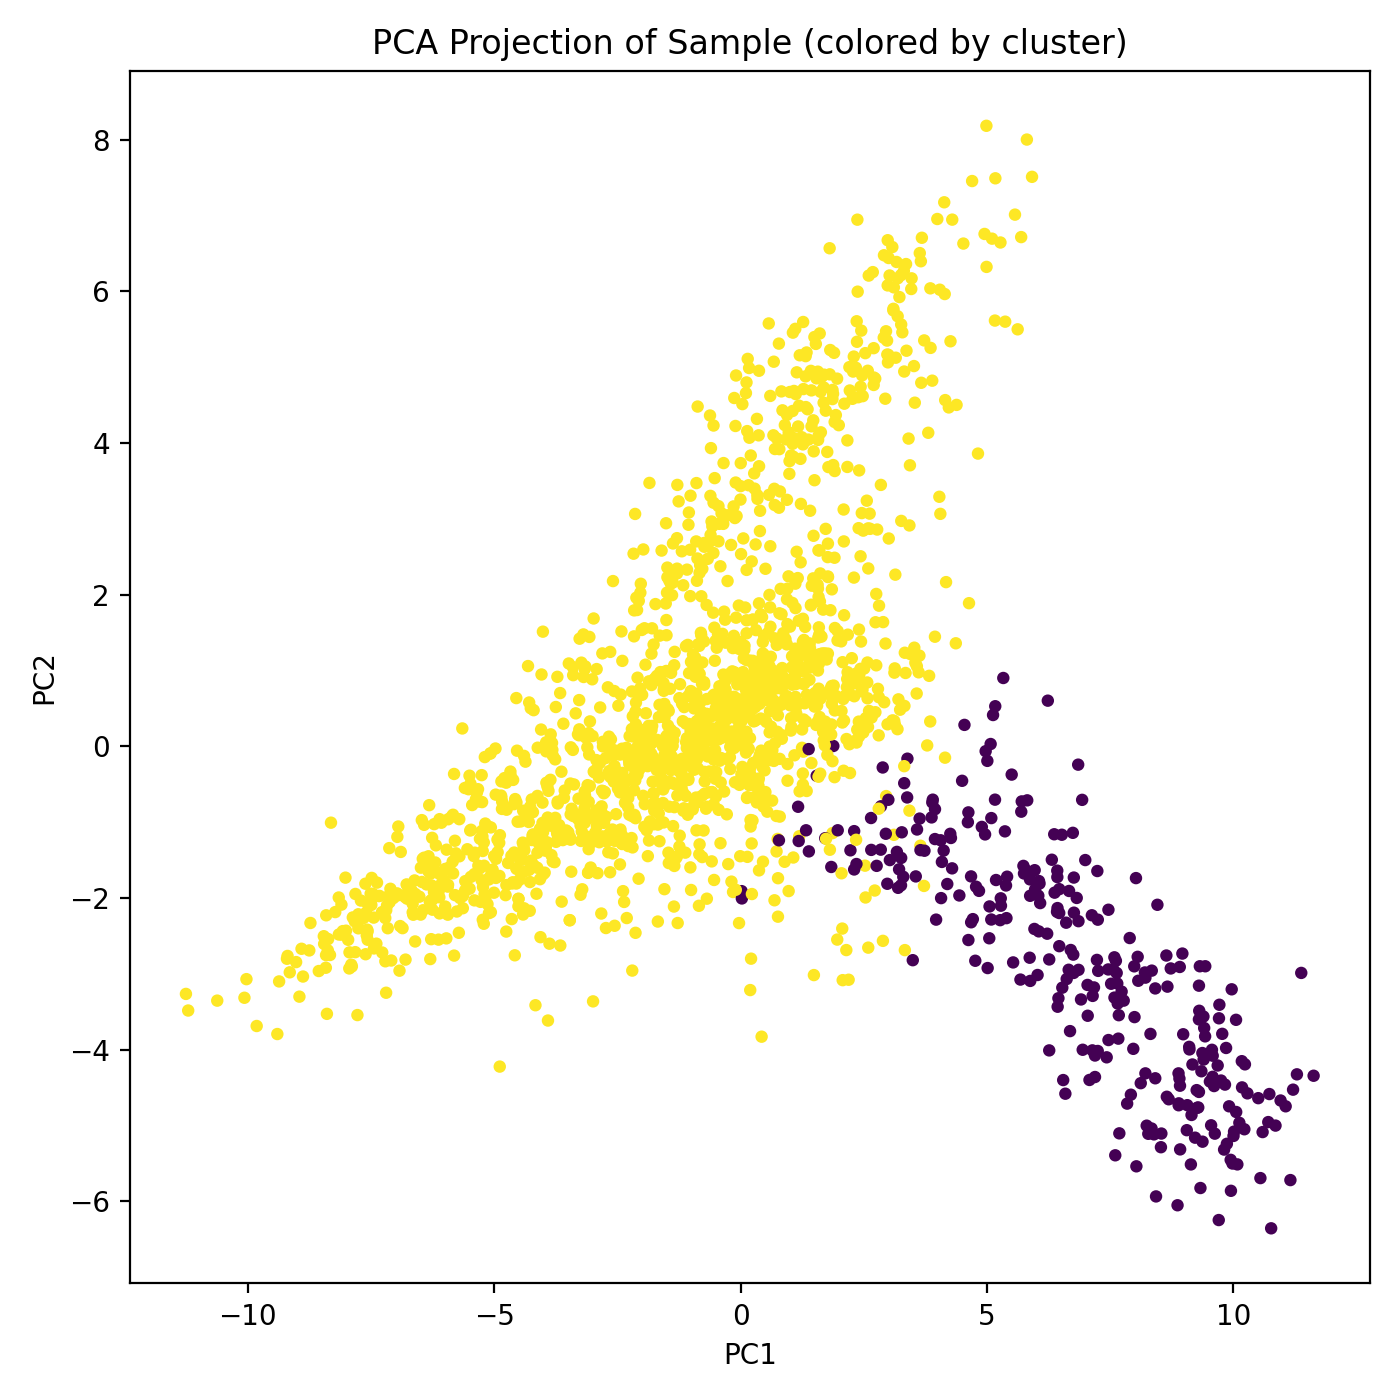

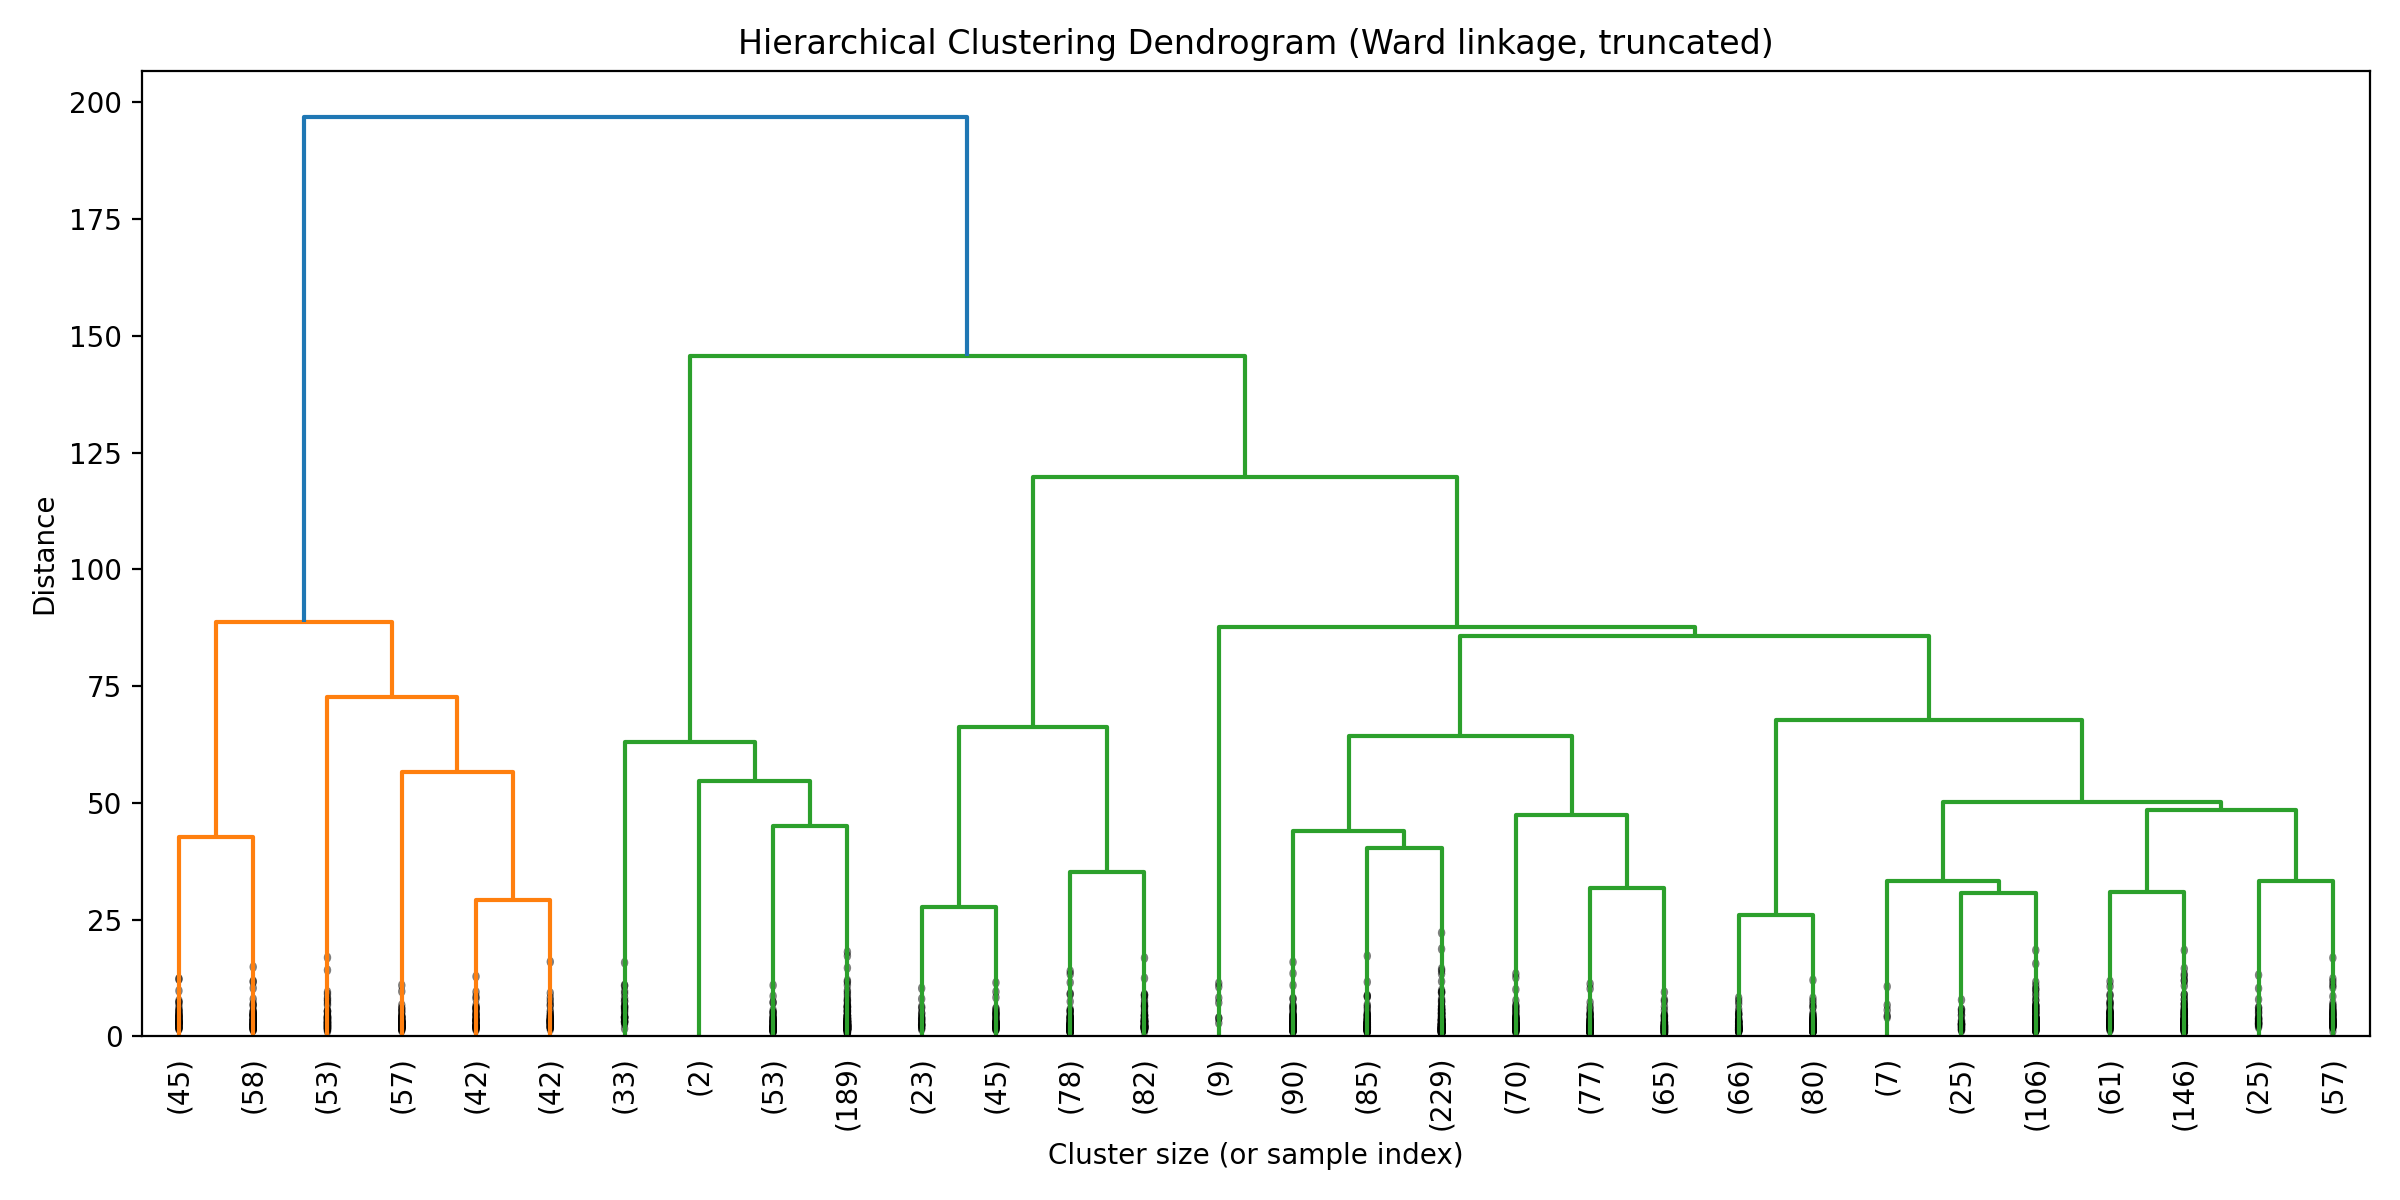

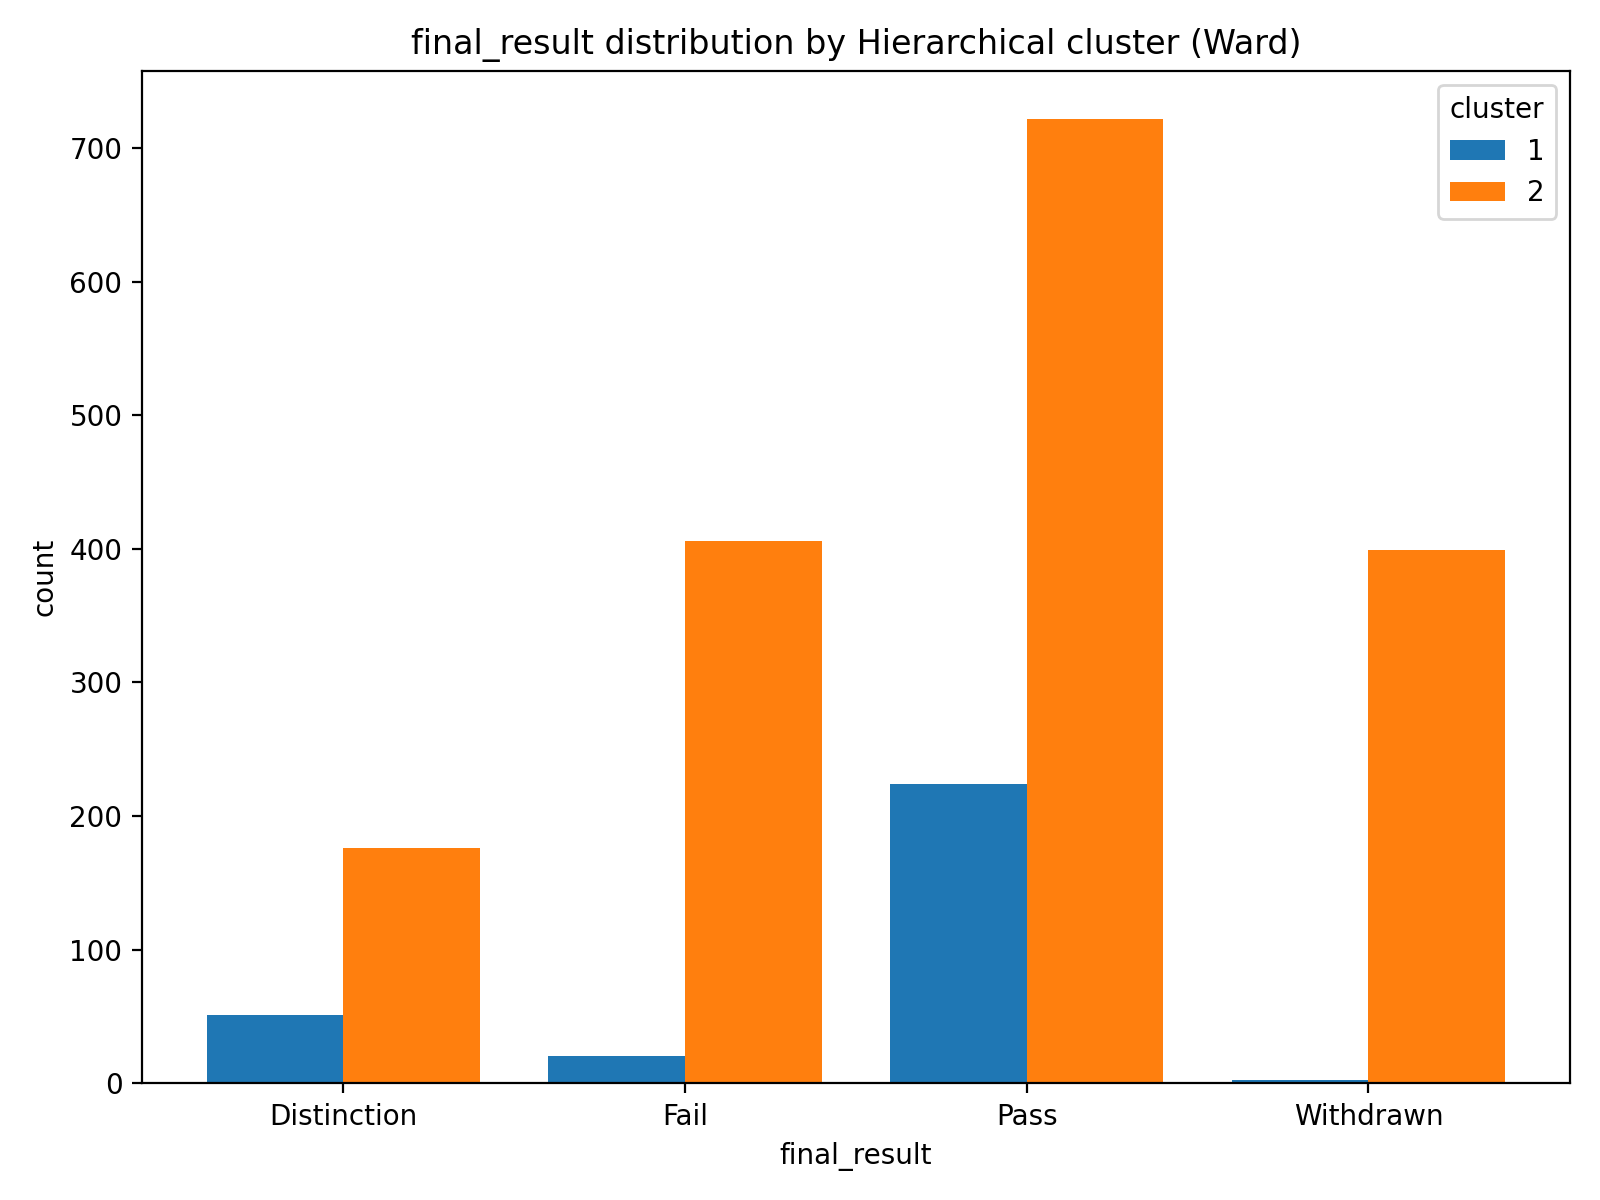

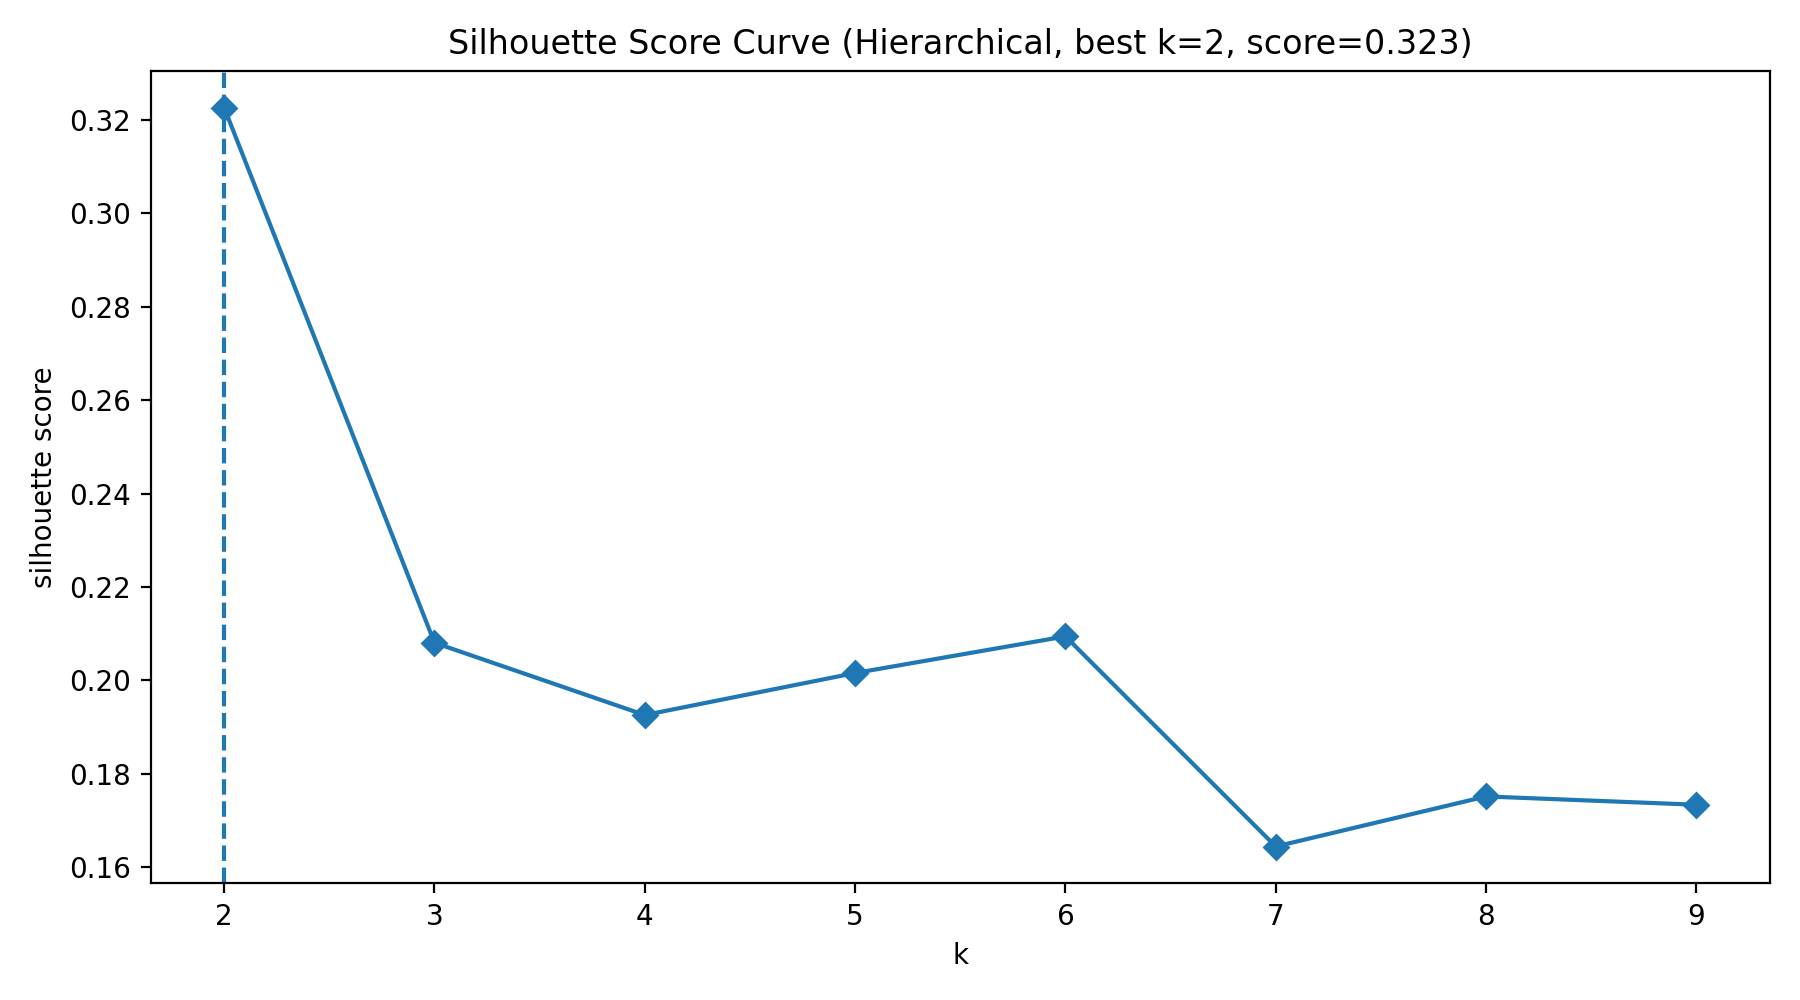

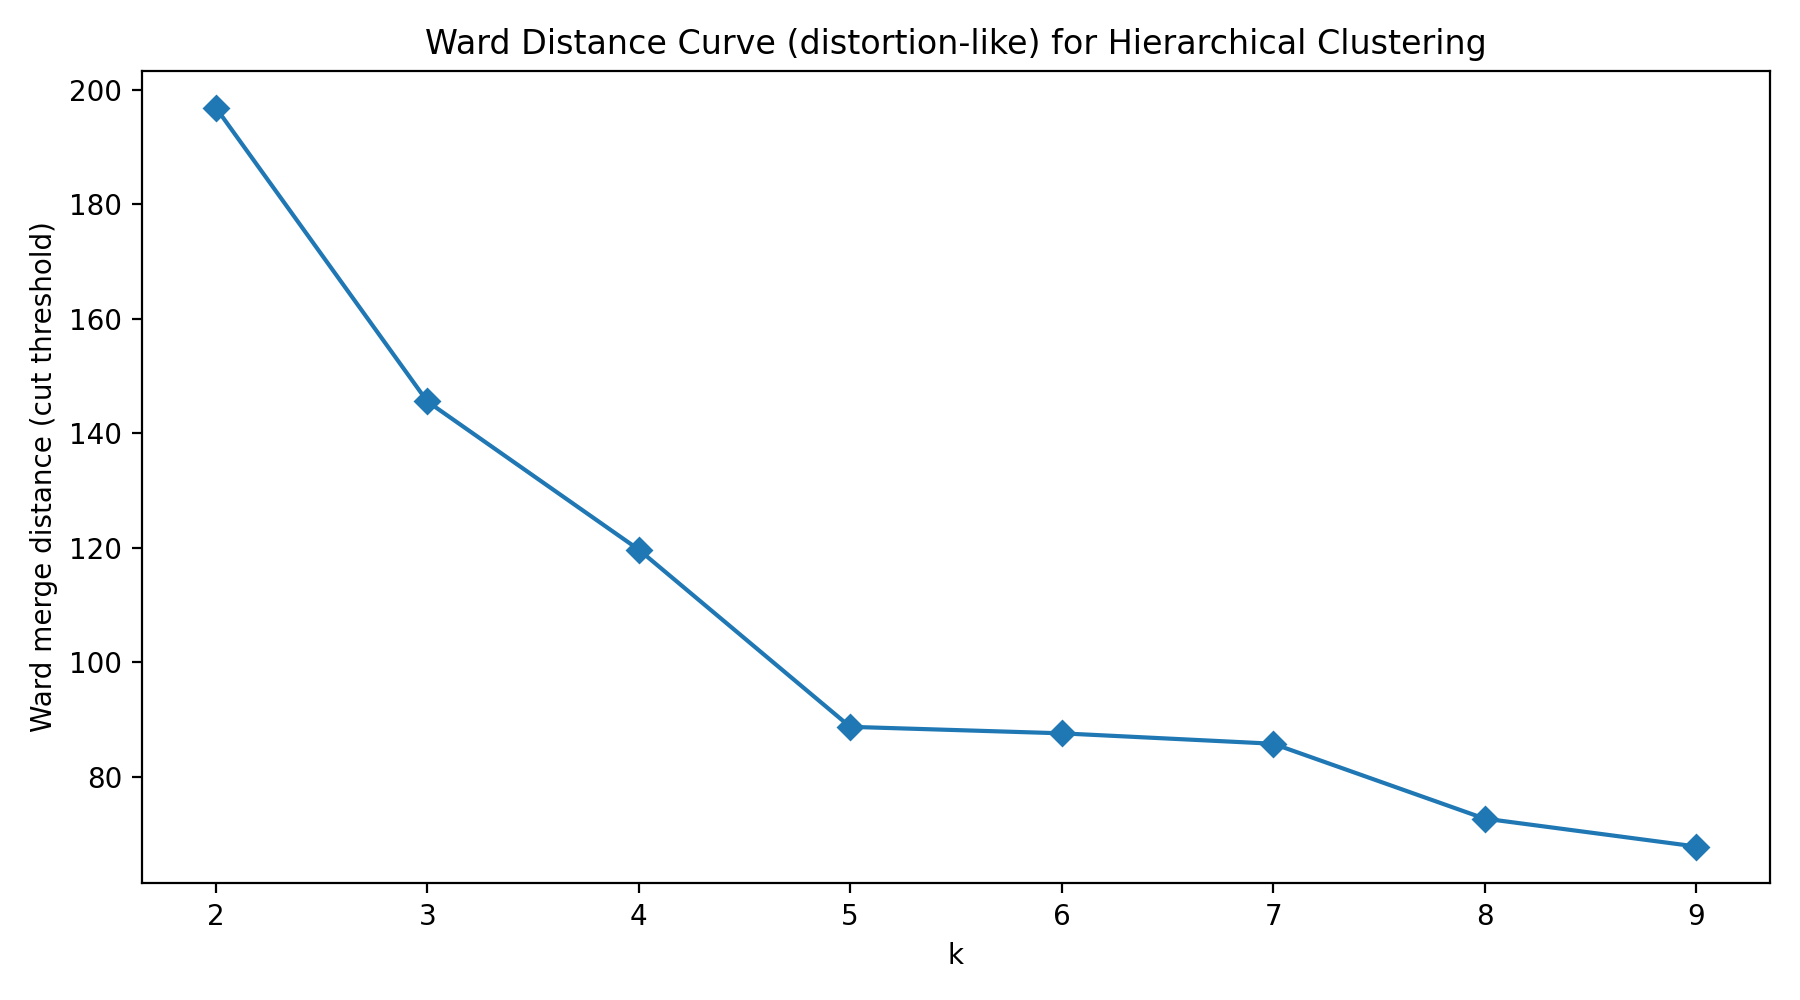

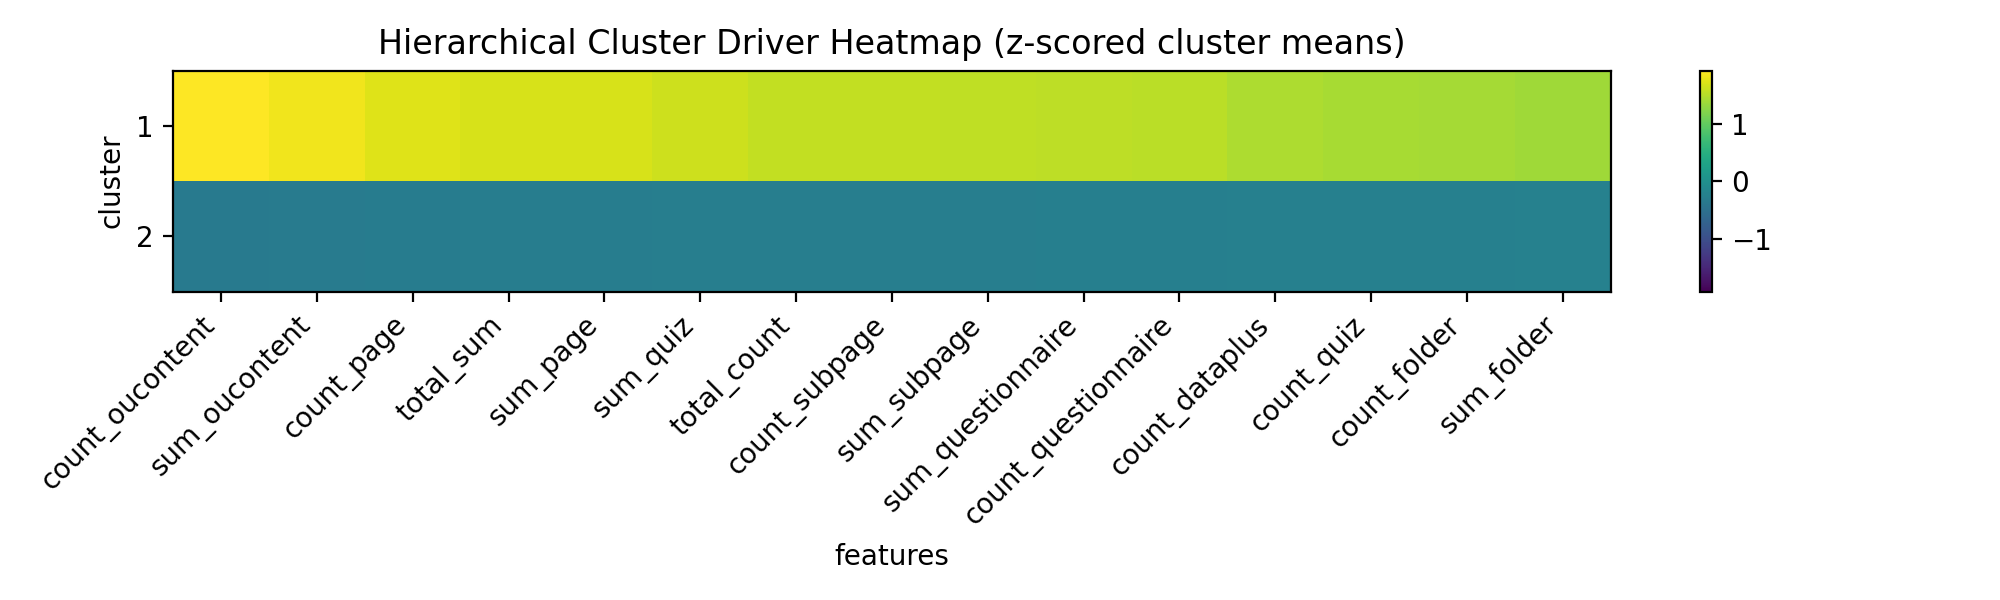

In [5]:
# ============================
# Show key plots
# ============================
print("Core plots:")
print(" - dendrogram:", results["core_plots"]["dendrogram"])
print(" - pca:", results["core_plots"]["pca"])

print("\nKMeans-like plots (for PPT):")
for k, v in results["kmeans_like_plots"].items():
    print(f" - {k}: {v}")

# Display images inline
for p in [
    results["core_plots"]["pca"],
    results["core_plots"]["dendrogram"],
    results["kmeans_like_plots"]["final_result_by_cluster"],
    results["kmeans_like_plots"]["silhouette_curve"],
    results["kmeans_like_plots"]["ward_distance_elbow"],
    results["kmeans_like_plots"]["driver_heatmap"],
]:
    if os.path.exists(p):
        display(Image(filename=p))


In [6]:
# ============================
# Inspect main CSV outputs
# ============================
print("Main outputs:")
for k, v in results["outputs"].items():
    print(k, ":", v)

assignments = pd.read_csv(results["outputs"]["assignments_csv"])
numeric_profile = pd.read_csv(results["outputs"]["numeric_profile_csv"])
drivers = pd.read_csv(results["outputs"]["top_numeric_drivers_csv"])

display(assignments.head())
display(numeric_profile.head())
display(drivers.head())

# Optional: show outcome distribution tables (if generated)
for col, path in results["outputs"]["outcome_distribution_csvs"].items():
    print(f"\nOutcome distribution: {col} -> {path}")
    df_dist = pd.read_csv(path)
    display(df_dist.head(20))


Main outputs:
assignments_csv : hc_outputs\student_course_clusters_sample.csv
numeric_profile_csv : hc_outputs\cluster_profile_numeric.csv
outcome_distribution_csvs : {'final_result': 'hc_outputs\\cluster_final_result_distribution.csv', 'completion_status': 'hc_outputs\\cluster_completion_status_distribution.csv', 'withdrawal_status': 'hc_outputs\\cluster_withdrawal_status_distribution.csv'}
top_numeric_drivers_csv : hc_outputs\cluster_top_numeric_drivers.csv


,id_student,code_module,code_presentation,cluster
0,24391,GGG,2013J,2
1,29411,DDD,2013J,2
2,29639,EEE,2014B,2
3,33796,DDD,2014J,2
4,34087,DDD,2013J,2


,cluster,sum_dataplus,sum_dualpane,sum_externalquiz,sum_folder,sum_forumng,sum_glossary,sum_homepage,sum_htmlactivity,sum_oucollaborate,...,n_assessments,mean_score,median_score,min_score,max_score,pct_score_missing,mean_weight,mean_submission_delay,pct_banked,n
0,1,137.508418,42.033670,0.00000,16.097643,5544.616162,12.188552,5893.356902,21.185185,57.710438,...,11.771044,78.85366,79.80808,61.097645,92.47138,0.000306,8.207528,-43.696312,0.004384,297
1,2,0.852026,1.263065,25.03993,0.000000,1977.784498,30.661186,1511.854375,0.221961,20.762184,...,5.773341,71.40534,72.38197,54.316500,84.94245,0.002535,13.988426,-7.314940,0.019579,1703


,cluster,direction,feature,effect_size
0,1,higher,count_oucontent,1.926469
1,1,higher,sum_oucontent,1.840389
2,1,higher,count_page,1.735631
3,1,higher,total_sum,1.685708
4,1,higher,sum_page,1.685679



Outcome distribution: final_result -> hc_outputs\cluster_final_result_distribution.csv


,cluster,final_result,proportion
0,1,Pass,0.754209
1,1,Distinction,0.171717
2,1,Fail,0.067340
3,1,Withdrawn,0.006734
4,2,Pass,0.423958
5,2,Fail,0.238403
6,2,Withdrawn,0.234292
7,2,Distinction,0.103347



Outcome distribution: completion_status -> hc_outputs\cluster_completion_status_distribution.csv


,cluster,completion_status,proportion
0,1,finished,0.993266
1,1,unfinished,0.006734
2,2,finished,0.765708
3,2,unfinished,0.234292



Outcome distribution: withdrawal_status -> hc_outputs\cluster_withdrawal_status_distribution.csv


,cluster,withdrawal_status,proportion
0,1,didn't withdraw,0.993266
1,1,late withdrawal,0.006734
2,1,normal withdrawal,0.000000
3,1,early withdrawal,0.000000
4,2,didn't withdraw,0.766295
5,2,late withdrawal,0.163829
6,2,normal withdrawal,0.068702
7,2,early withdrawal,0.001174
